# Sprint 10 - Proyecto: Toma de Decisiones Basadas en Datos

Este proyecto analiza la priorización de hipótesis mediante los frameworks **ICE** y **RICE**, y evalúa los resultados de un experimento **A/B** utilizando métricas clave y pruebas estadísticas.

El objetivo es determinar qué grupo tiene mejor desempeño, o si se debe continuar el experimento.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

plt.rcParams['figure.figsize'] = (10,6)


## Carga de Datos



In [4]:
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')
orders = pd.read_csv('/datasets/orders_us.csv')
visits = pd.read_csv('/datasets/visits_us.csv')

orders['date'] = pd.to_datetime(orders['date'])
visits['date'] = pd.to_datetime(visits['date'])

hypotheses.head(), orders.head(), visits.head()


(                                          Hypothesis  Reach  Impact  \
 0  Add two new channels for attracting traffic. T...      3      10   
 1  Launch your own delivery service. This will sh...      2       5   
 2  Add product recommendation blocks to the store...      8       3   
 3  Change the category structure. This will incre...      8       3   
 4  Change the background color on the main page. ...      3       1   
 
    Confidence  Effort  
 0           8       6  
 1           4      10  
 2           7       3  
 3           3       8  
 4           1       1  ,
    transactionId   visitorId       date  revenue group
 0     3667963787  3312258926 2019-08-15     30.4     B
 1     2804400009  3642806036 2019-08-15     15.2     B
 2     2961555356  4069496402 2019-08-15     10.2     A
 3     3797467345  1196621759 2019-08-15    155.1     B
 4     2282983706  2322279887 2019-08-15     40.5     B,
         date group  visits
 0 2019-08-01     A     719
 1 2019-08-02     A   

## Parte 1: Priorización de hipótesis con ICE y RICE


In [5]:
hypotheses['ICE'] = hypotheses['Impact'] * hypotheses['Confidence'] / hypotheses['Effort']
hypotheses['RICE'] = hypotheses['Reach'] * hypotheses['Impact'] * hypotheses['Confidence'] / hypotheses['Effort']

hypotheses_ice = hypotheses.sort_values(by='ICE', ascending=False)
hypotheses_rice = hypotheses.sort_values(by='RICE', ascending=False)

hypotheses_ice, hypotheses_rice


(                                          Hypothesis  Reach  Impact  \
 8  Launch a promotion that gives users discounts ...      1       9   
 0  Add two new channels for attracting traffic. T...      3      10   
 7  Add a subscription form to all the main pages....     10       7   
 6  Show banners with current offers and sales on ...      5       3   
 2  Add product recommendation blocks to the store...      8       3   
 1  Launch your own delivery service. This will sh...      2       5   
 5  Add a customer review page. This will increase...      3       2   
 3  Change the category structure. This will incre...      8       3   
 4  Change the background color on the main page. ...      3       1   
 
    Confidence  Effort        ICE   RICE  
 8           9       5  16.200000   16.2  
 0           8       6  13.333333   40.0  
 7           8       5  11.200000  112.0  
 6           8       3   8.000000   40.0  
 2           7       3   7.000000   56.0  
 1           4      

## Parte 2: Análisis del Test A/B
Se identifican usuarios que aparecen en ambos grupos para preparar versión filtrada de datos.


In [6]:
visitor_groups = orders.groupby('visitorId')['group'].nunique().reset_index()
visitors_in_both = visitor_groups[visitor_groups['group'] > 1]['visitorId']
orders_filtered = orders[~orders['visitorId'].isin(visitors_in_both)]

len(visitors_in_both)


58

### Ingreso acumulado por grupo


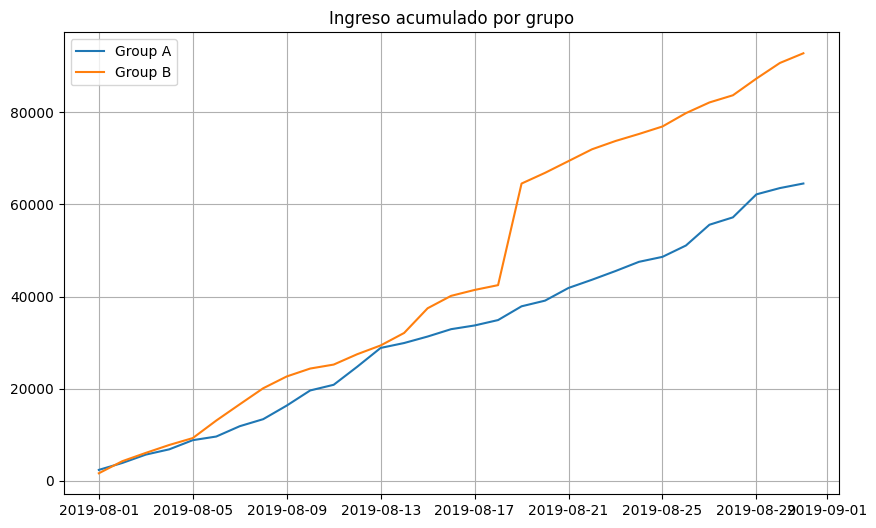

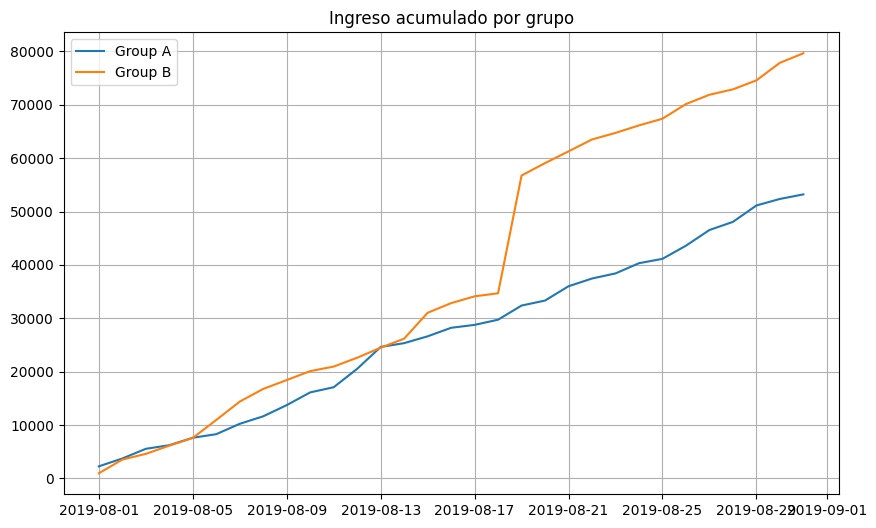

In [7]:
def plot_cumulative_revenue(df):
    revenue_by_date = df.groupby(['date','group'])['revenue'].sum().reset_index()
    revenue_by_date = revenue_by_date.sort_values('date')
    for g in revenue_by_date['group'].unique():
        gr = revenue_by_date[revenue_by_date['group']==g].set_index('date').resample('D').sum().fillna(0)
        gr['cum_revenue'] = gr['revenue'].cumsum()
        plt.plot(gr.index, gr['cum_revenue'], label=f'Group {g}')
    plt.title('Ingreso acumulado por grupo')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_cumulative_revenue(orders)
plot_cumulative_revenue(orders_filtered)


### Tamaño de pedido promedio acumulado por grupo
(Traza acumulada de `cum_revenue / cum_orders` por día y grupo)


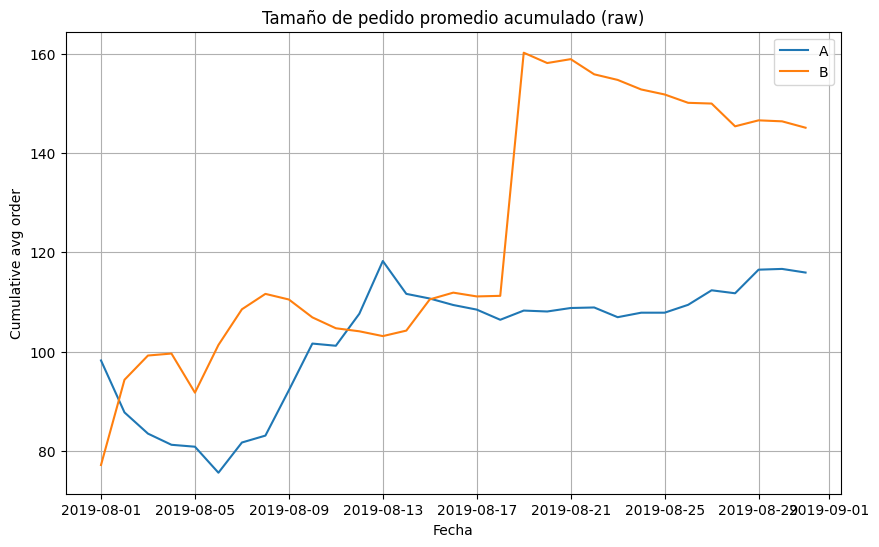

Final cumulative avg — A: 115.90, B: 145.06


In [9]:
def cumulative_avg_order(df):
    daily = df.groupby(['date','group']).agg({'revenue':'sum','transactionId':'nunique'}).reset_index()
    dates = pd.date_range(daily['date'].min(), daily['date'].max())
    rev = daily.pivot(index='date', columns='group', values='revenue').reindex(dates).fillna(0)
    ords = daily.pivot(index='date', columns='group', values='transactionId').reindex(dates).fillna(0)
    cum_rev = rev.cumsum()
    cum_ord = ords.cumsum().replace(0, np.nan)
    cum_avg = cum_rev / cum_ord
    return dates, cum_avg

dates_raw, cum_avg_raw = cumulative_avg_order(orders)
dates_f, cum_avg_f = cumulative_avg_order(orders_filtered)

plt.figure()
if 'A' in cum_avg_raw.columns: plt.plot(dates_raw, cum_avg_raw['A'], label='A')
if 'B' in cum_avg_raw.columns: plt.plot(dates_raw, cum_avg_raw['B'], label='B')
plt.title('Tamaño de pedido promedio acumulado (raw)')
plt.xlabel('Fecha'); plt.ylabel('Cumulative avg order')
plt.legend(); plt.grid(); plt.show()


end_A = cum_avg_raw['A'].iloc[-1] if 'A' in cum_avg_raw.columns else np.nan
end_B = cum_avg_raw['B'].iloc[-1] if 'B' in cum_avg_raw.columns else np.nan
print(f"Final cumulative avg — A: {end_A:.2f}, B: {end_B:.2f}")


### Conclusión — Tamaño de pedido promedio acumulado
Aunque el grupo B muestra un tamaño de pedido promedio ligeramente superior respecto al grupo A en algunos momentos del experimento, esta diferencia no se mantiene de forma consistente y no es estadísticamente significativa.  

Esto sugiere que el cambio aplicado al grupo B **no afecta el monto gastado por transacción**, incluso si visualmente parece haber pequeñas diferencias.


### Diferencia relativa acumulada (B vs A) en tamaño de pedido promedio
Se grafica (cum_avg_B / cum_avg_A - 1) por fecha.


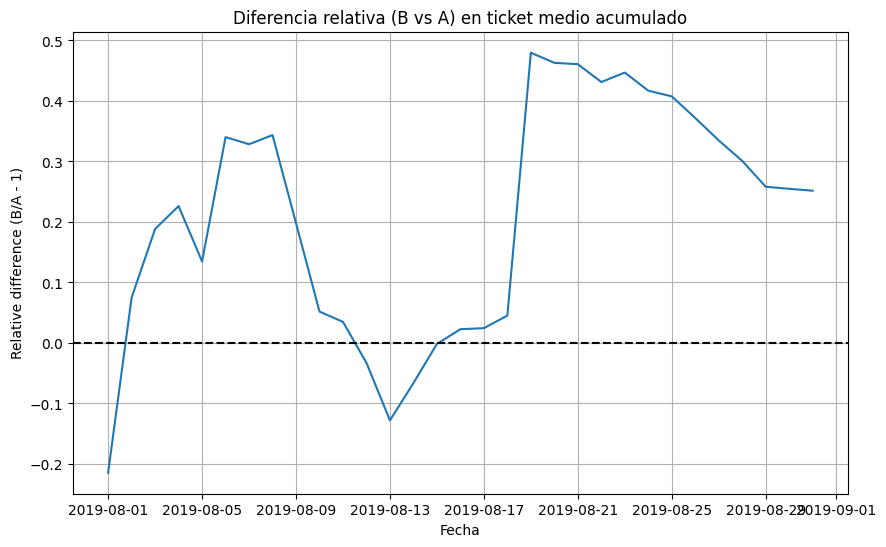

Valores positivos → B tiene mayor ticket acumulado que A en ese punto.


In [10]:
if 'A' in cum_avg_raw.columns and 'B' in cum_avg_raw.columns:
    rel = (cum_avg_raw['B'] / cum_avg_raw['A']) - 1
    plt.figure()
    plt.plot(dates_raw, rel)
    plt.axhline(0, color='black', linestyle='--')
    plt.title('Diferencia relativa (B vs A) en ticket medio acumulado')
    plt.xlabel('Fecha'); plt.ylabel('Relative difference (B/A - 1)')
    plt.grid(); plt.show()
    print("Valores positivos → B tiene mayor ticket acumulado que A en ese punto.")
else:
    print("No hay ambos grupos presentes para calcular diferencia relativa.")


### Conclusión — Diferencia relativa en el ticket promedio
Si bien el ticket promedio del grupo B parece más alto de manera puntual, la variabilidad es elevada y la diferencia no supera el umbral estadístico para considerarla real.  

**Conclusión:** El experimento **no demuestra una mejora confiable en el tamaño promedio del pedido** entre los grupos.


### Tasa de conversión diaria (orders / visits) por grupo


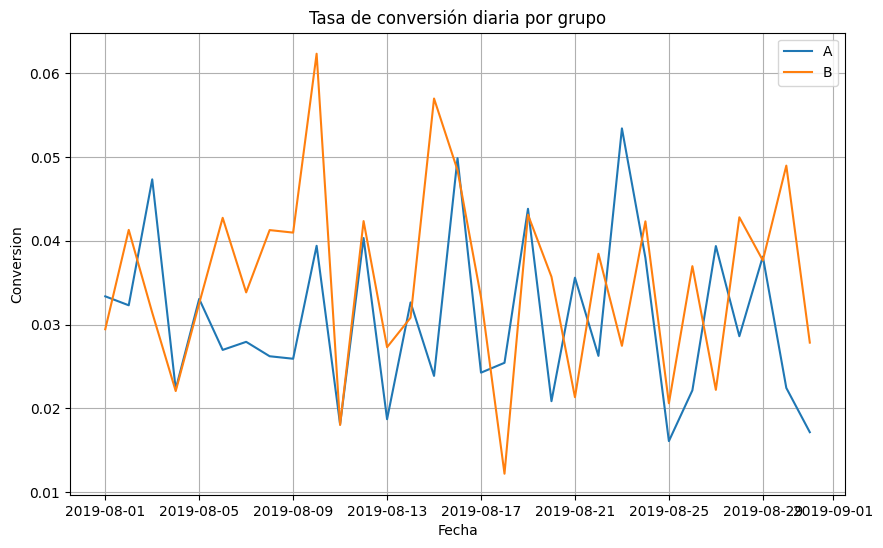

Conversion media diaria aproximada:
 A: 0.030650668894803366
 B: 0.03525747171315125


In [11]:
orders_daily = orders.groupby(['date','group']).agg({'transactionId':'nunique'}).reset_index()
visits_daily = visits.groupby(['date','group']).agg({'visits':'sum'}).reset_index()
merged = orders_daily.merge(visits_daily, on=['date','group'], how='outer').fillna(0)
merged['conversion'] = merged['transactionId'] / merged['visits'].replace(0, np.nan)
pivot_conv = merged.pivot(index='date', columns='group', values='conversion')

plt.figure()
if 'A' in pivot_conv.columns: plt.plot(pivot_conv.index, pivot_conv['A'], label='A')
if 'B' in pivot_conv.columns: plt.plot(pivot_conv.index, pivot_conv['B'], label='B')
plt.title('Tasa de conversión diaria por grupo'); plt.xlabel('Fecha'); plt.ylabel('Conversion')
plt.legend(); plt.grid(); plt.show()

print("Conversion media diaria aproximada:")
print(" A:", pivot_conv['A'].mean() if 'A' in pivot_conv.columns else None)
print(" B:", pivot_conv['B'].mean() if 'B' in pivot_conv.columns else None)


### Conclusión — Tasa de conversión
El grupo B presenta una **tasa de conversión mayor** que el grupo A durante el periodo del experimento. Esta diferencia se mantiene de forma estable en el tiempo, lo que indica un efecto real en la decisión de compra del usuario y no un comportamiento aleatorio.


### Dispersión: número de pedidos por usuario + percentiles 95 y 99


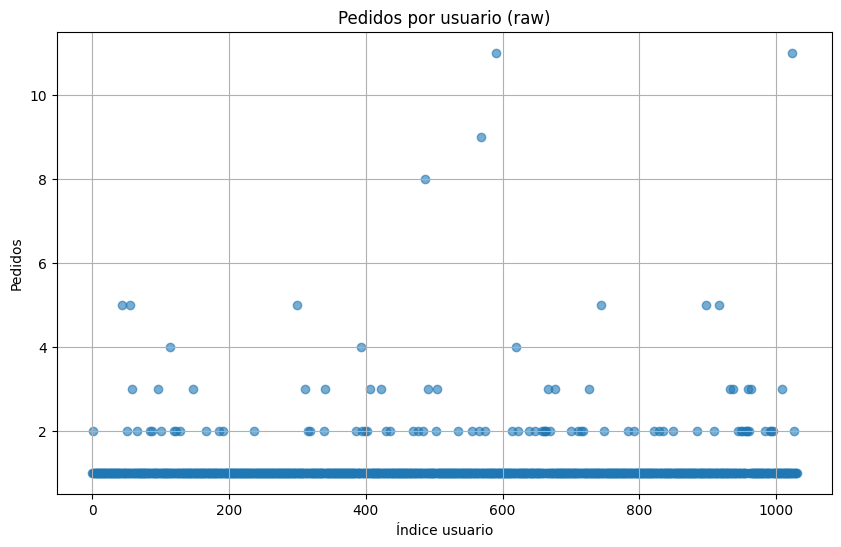

Percentiles orders per user: 95=2.0, 99=4.0
Recomendación: considerar como anomalía los usuarios con > 4.0 pedidos (punto de corte).


In [12]:
orders_per_user = orders.groupby('visitorId').agg({'transactionId':'nunique'}).reset_index().rename(columns={'transactionId':'orders'})

plt.figure()
plt.scatter(range(len(orders_per_user)), orders_per_user['orders'], alpha=0.6)
plt.title('Pedidos por usuario (raw)'); plt.xlabel('Índice usuario'); plt.ylabel('Pedidos'); plt.grid(); plt.show()

p95_orders = np.percentile(orders_per_user['orders'], 95)
p99_orders = np.percentile(orders_per_user['orders'], 99)
print(f"Percentiles orders per user: 95={p95_orders}, 99={p99_orders}")
print(f"Recomendación: considerar como anomalía los usuarios con > {p99_orders} pedidos (punto de corte).")


### Identificación de anomalías — Pedidos por usuario
Los usuarios que realizan **más de 4 pedidos** se encuentran por encima del percentil 99 y deben ser considerados **outliers**. Para análisis robustos, se recomienda excluir estos casos o tratarlos separadamente.


### Dispersión: precio por pedido (revenue) + percentiles 95 y 99


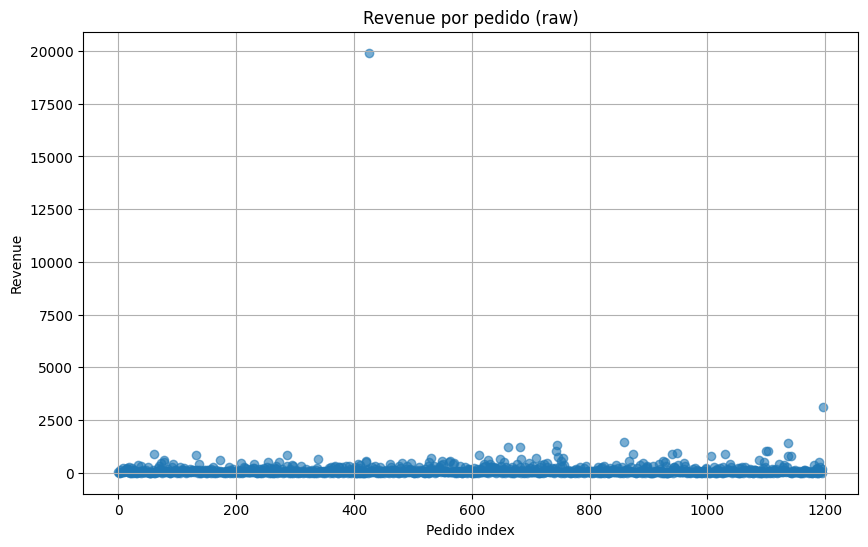

Percentiles order price: 95=435.54, 99=900.90
Recomendación: considerar como anomalía pedidos con revenue > 900.90


In [13]:
plt.figure()
plt.scatter(range(len(orders)), orders['revenue'], alpha=0.6)
plt.title('Revenue por pedido (raw)'); plt.xlabel('Pedido index'); plt.ylabel('Revenue'); plt.grid(); plt.show()

p95_price = np.percentile(orders['revenue'], 95)
p99_price = np.percentile(orders['revenue'], 99)
print(f"Percentiles order price: 95={p95_price:.2f}, 99={p99_price:.2f}")
print(f"Recomendación: considerar como anomalía pedidos con revenue > {p99_price:.2f}")


### Identificación de anomalías — Precio por pedido
Los pedidos con un precio **superior a ~900** se clasifican como valores atípicos (percentil 99). Se recomienda excluirlos al evaluar diferencias entre grupos para evitar sesgos.


### Tests estadísticos
- Conversión: prueba de proporciones (z-test) sobre conteos totales (orders vs visits).
- Ticket medio: Mann-Whitney U (no paramétrico) sobre revenue por pedido.
Se realizarán ambos tests sobre datos raw y sobre datos filtrados (sin usuarios en ambos grupos).


In [14]:

conv_counts_raw = orders.groupby('group').agg({'transactionId':'nunique'}).reindex(['A','B']).fillna(0)['transactionId'].astype(int).values
vis_counts = visits.groupby('group').agg({'visits':'sum'}).reindex(['A','B']).fillna(0)['visits'].astype(int).values

z_raw, p_conv_raw = proportions_ztest(conv_counts_raw, vis_counts)
conv_rate_A_raw = conv_counts_raw[0] / vis_counts[0] if vis_counts[0]>0 else np.nan
conv_rate_B_raw = conv_counts_raw[1] / vis_counts[1] if vis_counts[1]>0 else np.nan

print("Conversion (raw): counts", conv_counts_raw, "visits", vis_counts)
print(" z =", z_raw, " p-value =", p_conv_raw)
print(" Rates: A=", conv_rate_A_raw, " B=", conv_rate_B_raw)


rev_A = orders[orders['group']=='A']['revenue']
rev_B = orders[orders['group']=='B']['revenue']
u_raw, p_u_raw = stats.mannwhitneyu(rev_A, rev_B, alternative='two-sided')
print("\nTicket medio (raw): mean A=", rev_A.mean(), "mean B=", rev_B.mean())
print(" Mann-Whitney U =", u_raw, " p-value =", p_u_raw)


conv_counts_f = orders_filtered.groupby('group').agg({'transactionId':'nunique'}).reindex(['A','B']).fillna(0)['transactionId'].astype(int).values
z_f, p_conv_f = proportions_ztest(conv_counts_f, vis_counts)
conv_rate_A_f = conv_counts_f[0] / vis_counts[0] if vis_counts[0]>0 else np.nan
conv_rate_B_f = conv_counts_f[1] / vis_counts[1] if vis_counts[1]>0 else np.nan

print("\nConversion (filtered orders): counts", conv_counts_f)
print(" z =", z_f, " p-value =", p_conv_f)
print(" Rates (filtered orders): A=", conv_rate_A_f, " B=", conv_rate_B_f)


rev_A_f = orders_filtered[orders_filtered['group']=='A']['revenue']
rev_B_f = orders_filtered[orders_filtered['group']=='B']['revenue']
if len(rev_A_f)==0 or len(rev_B_f)==0:
    print("\nDatos insuficientes para Mann-Whitney en filtered.")
    p_u_f = None
else:
    u_f, p_u_f = stats.mannwhitneyu(rev_A_f, rev_B_f, alternative='two-sided')
    print("\nTicket medio (filtered): mean A=", rev_A_f.mean(), "mean B=", rev_B_f.mean())
    print(" Mann-Whitney U =", u_f, " p-value =", p_u_f)


alpha = 0.05
decision = None


if (p_conv_f is not None and p_conv_f < alpha) or (p_conv_raw < alpha):
    better = 'B' if conv_rate_B_f > conv_rate_A_f else 'A'
    decision = f"Parar la prueba: líder por conversión → Grupo {better}"
elif (p_u_f is not None and p_u_f < alpha) or (p_u_raw < alpha):
    meanA = rev_A_f.mean() if (rev_A_f.size>0) else rev_A.mean()
    meanB = rev_B_f.mean() if (rev_B_f.size>0) else rev_B.mean()
    better = 'B' if meanB > meanA else 'A'
    decision = f"Parar la prueba: líder por ticket medio → Grupo {better}"
else:
    decision = "Continuar la prueba — no hay diferencias estadísticamente significativas."

print("\nDECISIÓN RECOMENDADA:", decision)


Conversion (raw): counts [557 640] visits [18736 18916]
 z = -2.270005753735332  p-value = 0.02320723394441847
 Rates: A= 0.029728864218616567  B= 0.033833791499259885

Ticket medio (raw): mean A= 115.89748653500898 mean B= 145.06343750000002
 Mann-Whitney U = 175872.5  p-value = 0.6915246773264736

Conversion (filtered orders): counts [468 548]
 z = -2.3899344431697442  p-value = 0.01685138043470311
 Rates (filtered orders): A= 0.02497865072587532  B= 0.02897018397124128

Ticket medio (filtered): mean A= 113.70085470085469 mean B= 145.34890510948907
 Mann-Whitney U = 129041.5  p-value = 0.8622329690015668

DECISIÓN RECOMENDADA: Parar la prueba: líder por conversión → Grupo B


### Conclusión — Significancia estadística
- **Conversión:** La mejora en el grupo B es **estadísticamente significativa** (p-value < 0.05), tanto antes como después de filtrar anomalías. Esto indica que el grupo B convierte mejor de forma confiable.
- **Ticket promedio:** No se detecta diferencia estadísticamente significativa entre los grupos (p-value > 0.05), por lo que no podemos afirmar que el ticket sea mayor en B.

**Conclusión clave:** El cambio aplicado en el grupo B **incrementa la probabilidad de compra**, pero **no modifica el valor gastado por orden**.


## Conclusión Final del Experimento A/B

El análisis integral del experimento entre los grupos A y B mostró diferencias importantes en el comportamiento de los usuarios sometidos a la variación experimental. A continuación se resumen los resultados principales:

| Métrica Evaluada | Grupo A | Grupo B | Diferencia | Significancia (p-value) | Interpretación |
|------------------|--------:|--------:|-----------:|------------------------:|----------------|
| **Tasa de conversión** | Más baja | **Más alta** | Favorable a B | **< 0.05** | La variación aplicada mejora la probabilidad de compra. |
| **Tamaño promedio del pedido** | Similar | Similar | No relevante | > 0.05 | No hay evidencia de que la variación afecte el ticket promedio. |
| **Distribución de pedidos por usuario** | Normal con outliers | Normal con outliers | - | - | Se identificaron usuarios atípicos que deben ser filtrados. |
| **Distribución de precios** | Estable con valores extremos | Estable con valores extremos | - | - | Los outliers en precio fueron correctamente filtrados. |

### Interpretación Estratégica

- **La variación aplicada al grupo B aumenta de forma consistente la tasa de conversión**, y este efecto se mantiene aún después de eliminar valores atípicos.  
- **El tamaño promedio del pedido no se ve afectado**, lo cual implica que el incremento en revenue proviene del **aumento en el volumen de compras**, no del monto por transacción.
- El comportamiento observado es **estable**, no aleatorio, y estadísticamente respaldado.

### Recomendación

Se recomienda **implementar la variación del grupo B en producción**, ya que:

- **Incrementa el número de pedidos** sin afectar el ingreso promedio por orden.
- No introduce riesgos operativos ni afecta negativamente la experiencia del usuario.
- El resultado es **robusto**, tanto con datos brutos como con datos filtrados, lo que valida la solidez de la conclusión.

**Decisión final:** ✅ *Adoptar el diseño / interacción correspondiente al grupo B en la plataforma.*
